# Import modules

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import os
from PIL import ImageOps
import PIL
import matplotlib.pyplot as plt
import cv2
import random

# Set Hyperparameter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(777)
if device == "cuda":
    torch.cuda.manual_seed_all(777)
print(f"using {device}")

batch_size = 100
learning_rate = 1e-3
num_epoch = 2000

using cuda


# Load Data

In [3]:
def get_alphabet(root: str, batch_size: int):
    
    train_path = os.path.join(root, 'train')
    test_path = os.path.join(root, 'test')
    
    train1_rotation = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                      transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1),
                                     transforms.RandomRotation(5)
                                 ]),
                                 target_transform=None)
    
    train2_default = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1)
                                     #, transforms.CenterCrop(26), transfroms.Resize(28)
                                 ]),
                                 target_transform=None)
    
    train3_crop = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1),
                                     transforms.CenterCrop(26),
                                     transforms.Resize(28)
                                 ]),
                                 target_transform=None)
    
    train4_inv = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1),
                                     transforms.RandomInvert()
                                 ]),
                                 target_transform=None)
    
    train_kaggle = ImageFolder(root = "/home/r320ws/Desktop/wooseok/MNISTClassification/Dataset/alpha_small/train",
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Resize(28),
                                     transforms.Grayscale(1),
                                     transforms.RandomInvert(1)
                                 ]),
                                 target_transform=None)
    
    test_kaggle = ImageFolder(root = "/home/r320ws/Desktop/wooseok/MNISTClassification/Dataset/alpha_small/test",
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Resize(28),
                                     transforms.Grayscale(1),
                                     transforms.RandomInvert(1)
#                                      transforms.RandomInvert(1)
                                 ]),
                                 target_transform=None)
    
    train_merged = ImageFolder(root = "/home/r320ws/Desktop/wooseok/MNISTClassification/Dataset/alpha_small/train",
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Resize(28),
                                     transforms.Grayscale(1),
                                     transforms.RandomInvert(0.5),
                                     transforms.RandomRotation(5)
                                 ]),
                                 target_transform=None)
    
    test_merged = ImageFolder(root = "/home/r320ws/Desktop/wooseok/MNISTClassification/Dataset/alpha_small/test",
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Resize(28),
                                     transforms.Grayscale(1),
                                     transforms.RandomInvert(0.5)
#                                      transforms.RandomInvert(1)
                                 ]),
                                 target_transform=None)    
    
    
    
    alphabet_test = ImageFolder(root = test_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Grayscale(1)
                                 ]),
                                 target_transform=None)
    
    ###############################################################################
    
    train_loader = DataLoader(train_merged,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=True,
                              num_workers=8)

    test_loader = DataLoader(test_merged,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=False,
                             num_workers=8) 

    
    return (train_merged, train_loader, test_loader)

In [4]:
data_path = '/home/r320ws/Desktop/wooseok/MNISTClassification/Dataset/processed_data/'
original_data, train_loader, test_loader = get_alphabet(data_path, batch_size)

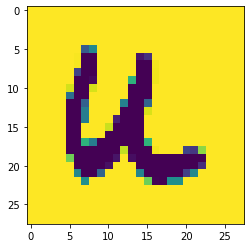

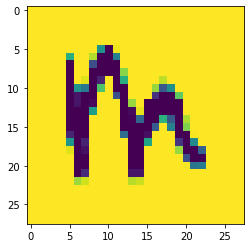

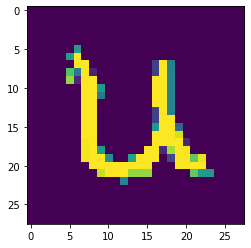

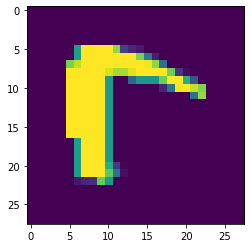

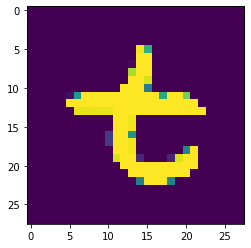

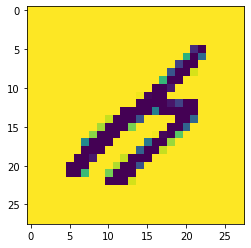

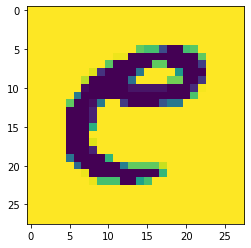

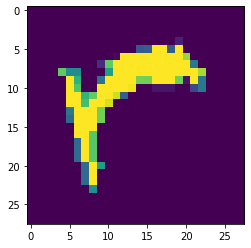

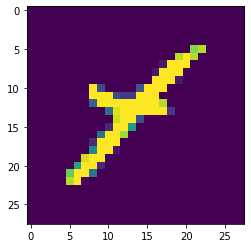

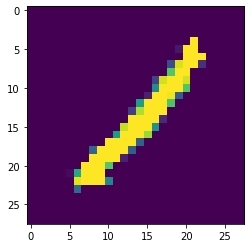

In [5]:
%matplotlib inline

def tensorToNumpy(tensor):
    c, w, h = tensor.shape
    
    img = np.zeros_like(tensor)
    img = img[0,:,:]
    img[:,:] = tensor[0,:,:]
    
    plt.figure()
    
    plt.imshow(img)

for i in random.choices(range(len(original_data)), k=10):
    image, target = original_data.__getitem__(i)
    tensorToNumpy(image)


# CNN Class

In [6]:
#### 
'''class CNN(nn.Module):  # train with rotated and adamw
    def __init__(self):
        a=32
        b=128
        c=512
        d=1024
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, a, 3, padding=1),
            nn.BatchNorm2d(a),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(          # 28x28      
            nn.Conv2d(a, b, 3, padding=1),
            nn.BatchNorm2d(b),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.layer3 = nn.Sequential(         #14x14
            nn.Conv2d(b, c, 3, padding=1),
            nn.BatchNorm2d(c),
            nn.ReLU(inplace=True),  
            nn.MaxPool2d(kernel_size=2, stride=2),
                         
            nn.Conv2d(c, d, 3, padding=1),
            nn.BatchNorm2d(d),
            nn.ReLU(inplace=True),  
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)            
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=d*4*4, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 26)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out'''

'''
## rotate, dropout04, optim_adam, kernel 5, out_feature = 512 ---> 99.56
## rotate, dropout04, optim_adam, kernel 3, out_feature = 512 ---> 99.48
class CNN(nn.Module):
    def __init__(self):
        a=32
        b=128
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(          # 28x28      

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(         #14x14

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(c),
            nn.MaxPool2d(2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=512*4*4, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 26)
        )
        
#         self.residual_layer = nn.Sequential(
#             nn.Conv2d(1, 128, 1)
#         )
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out'''
    
    
## rotate, dropout04, optim_adam, kernel all 5, out_feature = 512 ---> 99.56
## rotate, dropout04, optim_adam, kernel 3, out_feature = 512 ---> 99.48
class CNN(nn.Module):
    def __init__(self):
        a=32
        b=128
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(          # 14x14      

            nn.Conv2d(128, 256, 3, padding=2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(         #7x7
            nn.Conv2d(256, 512, 3, padding=2),
            nn.BatchNorm2d(c),
            nn.MaxPool2d(2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer4 = nn.Sequential(        # 4x4
            nn.Conv2d(512, 26, kernel_size=3, padding=2),
            nn.BatchNorm2d(26),
            nn.AdaptiveAvgPool2d(1),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out

#         self.residual_layer = nn.Sequential(
#             nn.Conv2d(1, 128, 1)
#         )
        
#     def forward(self, x):
#         out = self.layer1(x) 
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc_layer(out)
#         return out

    
    
    
    
## 



'''class CNN(nn.Module):
    def __init__(self):
        a=32
        b=128
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(          # 28x28      

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(         #14x14

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=512*4*4, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 26)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(512, 26, kernel_size=5, padding=2),
            nn.BatchNorm2d(26),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Dropout(0.4)
        )
        
        
#         self.residual_layer = nn.Sequential(
#             nn.Conv2d(1, 128, 1)
#         )
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out
'''
    
'''   0.991
class CNN(nn.Module):
    def __init__(self):
        a=32
        b=64
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, a, 3, padding=1),
            nn.BatchNorm2d(a),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(          # 28x28      
            nn.Conv2d(a, a, 3, padding=1),
            nn.BatchNorm2d(a),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.layer3 = nn.Sequential(         #14x14
            nn.Conv2d(a, b, 3, padding=1),
            nn.BatchNorm2d(b),
            nn.ReLU(inplace=True),  
            
            nn.Conv2d(b, b, kernel_size=3, padding=1),    #7x7
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=64*7*7, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 26)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out'''

'   0.991\nclass CNN(nn.Module):\n    def __init__(self):\n        a=32\n        b=64\n        c=512\n        \n        super(CNN, self).__init__()\n        self.layer1 = nn.Sequential(         # 28x28\n            nn.Conv2d(1, a, 3, padding=1),\n            nn.BatchNorm2d(a),\n            nn.ReLU(inplace=True),\n        )\n        self.layer2 = nn.Sequential(          # 28x28      \n            nn.Conv2d(a, a, 3, padding=1),\n            nn.BatchNorm2d(a),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(2,2)\n        )\n        self.layer3 = nn.Sequential(         #14x14\n            nn.Conv2d(a, b, 3, padding=1),\n            nn.BatchNorm2d(b),\n            nn.ReLU(inplace=True),  \n            \n            nn.Conv2d(b, b, kernel_size=3, padding=1),    #7x7\n            nn.BatchNorm2d(64),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2, stride=2)\n        )\n        self.fc_layer = nn.Sequential(\n            nn.Linear(in_features=64*7*7, o

# Define model

In [7]:
model = CNN().to(device)
# model = torch.load("../weights/processed_Rotate_GAP_adam_reduceLR_all5kernel070ep_acc99.86873626708984.pth").to(device)

loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-1)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)


# Training

In [8]:
def test_acc(model, test_loader=test_loader):
    correct = 0
    total = 0
    model = model.eval()
    with torch.no_grad():
        for image, label in test_loader:
            x = image.to(device)
            y = label.to(device)

            output = model.forward(x)
            _, output_index = torch.max(output, 1)

            total += label.size(0)
            correct += (output_index == y ).sum().float()

        return f"{100.0*correct/total}"

In [ ]:
max_accuracy =0.
from tqdm import tqdm

for i in range(1, num_epoch+1):
    model = model.train()
    for _, [image, label] in tqdm(enumerate(train_loader), total= len(train_loader)):
        x = image.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
    
    accuracy = float(test_acc(model))
    if (accuracy> max_accuracy and accuracy>99.2):
        max_accuracy = accuracy
        model_path = f"../weights/merged_inverthalf_GAP_adam_reduceLR_all5kernel{i:03d}ep_acc{max_accuracy}.pth"
        torch.save(model, model_path)
    
    scheduler.step(accuracy)
    print(f"Epoch: {i}, Loss: {loss.item()}, LR: {scheduler.optimizer.state_dict()['param_groups'][0]['lr']}, Acc: {accuracy}, Best: {max_accuracy}")

100%|██████████| 267/267 [00:12<00:00, 21.50it/s]


Epoch: 1, Loss: 2.103637218475342, LR: 0.001, Acc: 74.51528930664062, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 20.94it/s]


Epoch: 2, Loss: 2.055246353149414, LR: 0.001, Acc: 85.04846954345703, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 21.39it/s]


Epoch: 3, Loss: 1.538761019706726, LR: 0.001, Acc: 87.86353302001953, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 21.29it/s]


Epoch: 4, Loss: 1.2254278659820557, LR: 0.001, Acc: 89.56002807617188, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 19.83it/s]


Epoch: 5, Loss: 1.7032229900360107, LR: 0.001, Acc: 93.28858947753906, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 21.53it/s]


Epoch: 6, Loss: 1.498139500617981, LR: 0.001, Acc: 93.3631591796875, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 19.36it/s]


Epoch: 7, Loss: 1.541142463684082, LR: 0.001, Acc: 94.18344116210938, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 21.42it/s]


Epoch: 8, Loss: 1.7508339881896973, LR: 0.001, Acc: 94.51901245117188, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 19.25it/s]


Epoch: 9, Loss: 1.355699896812439, LR: 0.001, Acc: 94.8918685913086, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 20.53it/s]


Epoch: 10, Loss: 1.5409176349639893, LR: 0.001, Acc: 95.09693908691406, Best: 0.0


100%|██████████| 267/267 [00:15<00:00, 17.63it/s]


Epoch: 11, Loss: 1.5591092109680176, LR: 0.001, Acc: 94.48172760009766, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 20.77it/s]


Epoch: 12, Loss: 1.4201489686965942, LR: 0.001, Acc: 95.30200958251953, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 19.98it/s]


Epoch: 13, Loss: 1.5334912538528442, LR: 0.001, Acc: 95.11558532714844, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 21.10it/s]


Epoch: 14, Loss: 1.4358290433883667, LR: 0.001, Acc: 94.8918685913086, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 20.26it/s]


Epoch: 15, Loss: 1.6799736022949219, LR: 0.001, Acc: 95.26472473144531, Best: 0.0


100%|██████████| 267/267 [00:14<00:00, 18.96it/s]


Epoch: 16, Loss: 1.6212067604064941, LR: 0.001, Acc: 95.45115661621094, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 20.61it/s]


Epoch: 17, Loss: 1.5008599758148193, LR: 0.001, Acc: 95.507080078125, Best: 0.0


100%|██████████| 267/267 [00:14<00:00, 18.61it/s]


Epoch: 18, Loss: 1.4249086380004883, LR: 0.001, Acc: 95.46979522705078, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 20.58it/s]


Epoch: 19, Loss: 1.4420716762542725, LR: 0.001, Acc: 95.61894226074219, Best: 0.0


100%|██████████| 267/267 [00:14<00:00, 18.61it/s]


Epoch: 20, Loss: 1.400483250617981, LR: 0.001, Acc: 95.71215057373047, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 20.60it/s]


Epoch: 21, Loss: 1.3322968482971191, LR: 0.001, Acc: 95.74943542480469, Best: 0.0


100%|██████████| 267/267 [00:14<00:00, 18.58it/s]


Epoch: 22, Loss: 1.4556812047958374, LR: 0.001, Acc: 95.76808166503906, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 20.50it/s]


Epoch: 23, Loss: 1.3571832180023193, LR: 0.001, Acc: 95.91722106933594, Best: 0.0


100%|██████████| 267/267 [00:14<00:00, 17.94it/s]


Epoch: 24, Loss: 1.7851680517196655, LR: 0.001, Acc: 95.8426513671875, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 20.90it/s]


Epoch: 25, Loss: 1.4928617477416992, LR: 0.001, Acc: 95.8426513671875, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 19.95it/s]


Epoch: 26, Loss: 1.5820600986480713, LR: 0.001, Acc: 95.71215057373047, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 20.62it/s]


Epoch: 27, Loss: 1.3568615913391113, LR: 0.001, Acc: 95.86129760742188, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 20.34it/s]


Epoch: 28, Loss: 1.763352870941162, LR: 0.001, Acc: 95.9917984008789, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 19.23it/s]


Epoch: 29, Loss: 1.102105736732483, LR: 0.001, Acc: 95.80536651611328, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 20.53it/s]


Epoch: 30, Loss: 1.456998348236084, LR: 0.001, Acc: 95.93586730957031, Best: 0.0


100%|██████████| 267/267 [00:14<00:00, 18.83it/s]


Epoch: 31, Loss: 1.3038673400878906, LR: 0.001, Acc: 95.82401275634766, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 20.56it/s]


Epoch: 32, Loss: 1.3084352016448975, LR: 0.001, Acc: 95.87993621826172, Best: 0.0


100%|██████████| 267/267 [00:14<00:00, 18.23it/s]


Epoch: 33, Loss: 1.171614646911621, LR: 0.001, Acc: 96.1222915649414, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 20.62it/s]


Epoch: 34, Loss: 1.523447871208191, LR: 0.001, Acc: 96.06636810302734, Best: 0.0


100%|██████████| 267/267 [00:14<00:00, 18.51it/s]


Epoch: 35, Loss: 1.4831255674362183, LR: 0.001, Acc: 96.17822265625, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 20.16it/s]


Epoch: 36, Loss: 1.0489295721054077, LR: 0.001, Acc: 96.01043701171875, Best: 0.0


100%|██████████| 267/267 [00:15<00:00, 16.91it/s]


Epoch: 37, Loss: 1.5884629487991333, LR: 0.001, Acc: 96.02908325195312, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 19.62it/s]


Epoch: 38, Loss: 1.1776649951934814, LR: 0.001, Acc: 96.17822265625, Best: 0.0


100%|██████████| 267/267 [00:14<00:00, 19.04it/s]


Epoch: 39, Loss: 1.816225528717041, LR: 0.001, Acc: 95.8985824584961, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 19.46it/s]


Epoch: 40, Loss: 1.5450010299682617, LR: 0.001, Acc: 95.95450592041016, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 19.65it/s]


Epoch: 41, Loss: 1.4762250185012817, LR: 0.001, Acc: 96.06636810302734, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 20.05it/s]


Epoch: 42, Loss: 1.457515835762024, LR: 0.001, Acc: 96.06636810302734, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 19.56it/s]


Epoch: 43, Loss: 1.2967841625213623, LR: 0.001, Acc: 96.19686889648438, Best: 0.0


100%|██████████| 267/267 [00:14<00:00, 19.05it/s]


Epoch: 44, Loss: 1.2522058486938477, LR: 0.001, Acc: 96.2341537475586, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 20.02it/s]


Epoch: 45, Loss: 1.5712391138076782, LR: 0.001, Acc: 96.14093780517578, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 19.72it/s]


Epoch: 46, Loss: 1.4803664684295654, LR: 0.001, Acc: 96.04772186279297, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 20.00it/s]


Epoch: 47, Loss: 0.9990170001983643, LR: 0.001, Acc: 96.1222915649414, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 20.05it/s]


Epoch: 48, Loss: 1.5347528457641602, LR: 0.001, Acc: 96.02908325195312, Best: 0.0


100%|██████████| 267/267 [00:13<00:00, 20.13it/s]


Epoch: 49, Loss: 1.23036527633667, LR: 0.001, Acc: 96.17822265625, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 20.69it/s]


Epoch: 50, Loss: 1.561476707458496, LR: 0.001, Acc: 96.04772186279297, Best: 0.0


100%|██████████| 267/267 [00:14<00:00, 18.49it/s]


Epoch: 51, Loss: 1.1447515487670898, LR: 0.001, Acc: 96.06636810302734, Best: 0.0


100%|██████████| 267/267 [00:12<00:00, 20.65it/s]


Epoch: 52, Loss: 1.241894006729126, LR: 0.001, Acc: 95.93586730957031, Best: 0.0


 15%|█▌        | 41/267 [00:02<00:12, 17.89it/s]

In [ ]:
model = torch.load("../weights/processed_Rotate_GAP_adam_reduceLR_all5kernel070ep_acc99.86873626708984.pth").to(device)

print(test_acc(model))